## Import Libraries and Load data

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv('data/train.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


______________

## Data Exploration

In [37]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


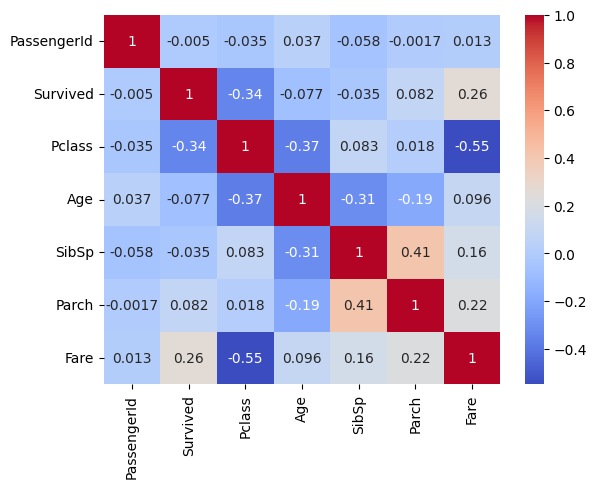

In [38]:
sns.heatmap(df.select_dtypes(include=['number']).corr(), cmap ='coolwarm', annot = True)
plt.show()

We can see that `Pclass` has a strong negative correlation with survival, while `Fare` shows a strong positive one. This makes sense — lower `Pclass` values indicate higher social class, and those passengers paid higher fares. So, it's fair to say that higher-status individuals had better chances of survival.
- Low `Pclass` --> High `fare` --> High `survived`

_______________

We've often heard that women had a higher chance of survival — and that's true. However, the correlation matrix doesn't show this because `Sex` is a non-numeric (categorical) feature. To analyze it, we can group the data by `Sex` and look at survival rates.


In [39]:
survival_by_sex = df.groupby('Sex')['Survived'].mean()
print(survival_by_sex)

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


So yeah, we can conclue that `sex` = `female` --> high `survived`

________

#### Before proceeding with Feature Engineering, let's split the data into training and testing sets using stratified sampling. We'll preserve the distribution of key categorical features — `Sex`, `Pclass`, and `Survived` — to ensure balanced representation across both sets.


In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

df['strata'] = df['Sex'].astype(str) + '_' + \
                         df['Survived'].astype(str) + '_' + \
                         df['Pclass'].astype(str)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in split.split(df, df['strata']):
    strat_train_set = df.loc[train_idx].drop(columns='strata')
    strat_val_set = df.loc[val_idx].drop(columns='strata')

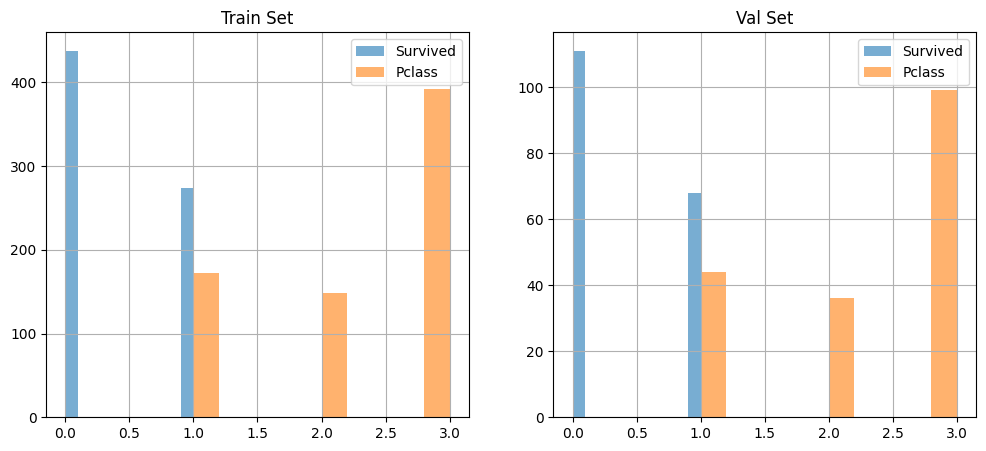

In [41]:
# Let's visualize 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
strat_train_set['Survived'].hist(alpha=0.6, label='Survived')
strat_train_set['Pclass'].hist(alpha=0.6, label='Pclass')
plt.title('Train Set')
plt.legend()

plt.subplot(1, 2, 2)
strat_val_set['Survived'].hist(alpha=0.6, label='Survived')
strat_val_set['Pclass'].hist(alpha=0.6, label='Pclass')
plt.title('Val Set')

plt.legend()

______

## Feature Engineering

In [42]:
strat_train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            139
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         1
dtype: int64

We can observe that `age` and `cabin` has null values. Since `cabin` has only 163 non-null values it makes more sense to just drop them and deal with `age` column alone 

In [43]:
from preprocessing_pipeline import AgeImputer, FeatureEncoder, FeatureDropper
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredroper", FeatureDropper())
])

strat_train_set = pipeline.fit_transform(strat_train_set)

In [44]:
strat_train_set.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
294,0,3,24.0,0,0,7.8958,0.0,1.0,0.0,0.0,1.0
461,0,3,34.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
392,0,3,28.0,2,0,7.9250,0.0,1.0,0.0,0.0,1.0
626,0,2,57.0,0,0,12.3500,0.0,1.0,0.0,1.0,0.0
393,1,1,23.0,1,0,113.2750,1.0,0.0,1.0,0.0,0.0


In [45]:
strat_train_set.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [46]:
from sklearn.preprocessing import StandardScaler

X_train = strat_train_set.drop("Survived", axis=1)
y_train = strat_train_set["Survived"].copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = y_train.to_numpy()

_____

## Train and Build the Model

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [48]:
strat_val_set = pipeline.transform(strat_val_set)

X_val = strat_val_set.drop("Survived", axis=1)
y_val = strat_val_set["Survived"].copy()

X_val = scaler.transform(X_val)
y_val = y_val.to_numpy()

c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [49]:
from sklearn.metrics import accuracy_score

y_val_pred = best_model.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Val Accuracy: {val_accuracy:.4f}")

Val Accuracy: 0.7933


We can observe that val `accuracy` is `0.79` which is pretty decent

_____

#### Now Lets use the full training data and fit to our best model and train it.

In [53]:
full_train_data = pipeline.fit_transform(df)
full_train_data = full_train_data.drop(columns='strata')

In [54]:
full_train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [55]:
X_final = full_train_data.drop("Survived", axis=1)
y_final = full_train_data["Survived"].copy()

X_final = scaler.transform(X_final)
y_final = y_final.to_numpy()

best_model.fit(X_final, y_final)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

#### Let us make predictions on the actual `test data`

In [56]:
test_data = pd.read_csv("data/test.csv")
passenger_ids = test_data["PassengerId"].copy()

test_data = pipeline.transform(test_data)

X_test = scaler.transform(test_data)

test_preds = best_model.predict(X_test)


c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


___________

Exporting `PassengerId` and `Survived` ( our prediction) columns in a csv file for submitting in kaggle.

In [ ]:
submission_df = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": test_preds.astype(int)
})
submission_df.to_csv("submission.csv", index=False)

______________